<a href="https://colab.research.google.com/github/gmazzitelli/GSN2/blob/master/IFNFCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

## setup generale
</div>
load funzioni e dati

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":11,"axes.titlesize":16,"axes.labelsize":11})

def Exp(x, p0, p1): # negative exponential
  import numpy as np
  return p0*np.exp(x/p1)

def Line(x, m, q):
  import numpy as np
  return m*x + q

def Gain(x, p0, p1):
  import numpy as np
  return p0*x**p1

def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
  # google spredsheet TO panda dataframe
  # ricordarsi di abilitare lo sharing pubblico dei dati

  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url, header=header)

# df =  panda_from_gspreadsheet('1MWRb1xbkpZOmUBLCLaC9ud4htvPEWYC7F8IuTt84YBg', sheet_name='Sheet1')
df =  panda_from_gspreadsheet('1bPAhcjzy2BQFaGO2-I3_XsZSpZ0060jcwqIyuPkxR2w', sheet_name='Sheet1')
df.tail(1)


,Timestamp,Email Address,Experiment or project/initiative,Unnamed: 3,Computing model evolution,Real Data amount,Real Data size,Data structure,Metadata/calibrations/slow-control,Production sites,...,CPU - total amount (III),CPU - total amount (II),Storage - size (III),Storage - size (II),Tape - size (III),Tape - size (II),Score,Additional comments/specifications,Storage - size,Storage - size.1
68,10/26/2023 10:17:57,daniele.spiga@pg.infn.it,CMS,NaN,Currently defined and in evolution within the ...,>100M,100kB-1MB,5 main levels: RAW - RECO -AOD -MiniAOD -Nano...,Calibration data,Data Repacked at Tier0 are distributed to the ...,...,>1000,10-30%,NaN,10-30%,>10PB,10-30%,NaN,NaN,NaN,NaN


<div class="markdown-google-sans">

## partecipazione
</div>

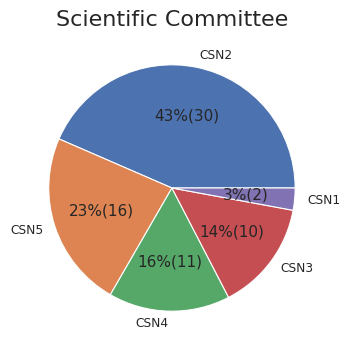

In [23]:
fig, ax = plt.subplots(figsize=(4,4))
what = "Scientific Committee"
elements = len(df[what])
pd.value_counts(df[what]).plot(kind='pie', autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
plt.title(what)
plt.show()

<div class="markdown-google-sans">

## Computing model evolution
</div>



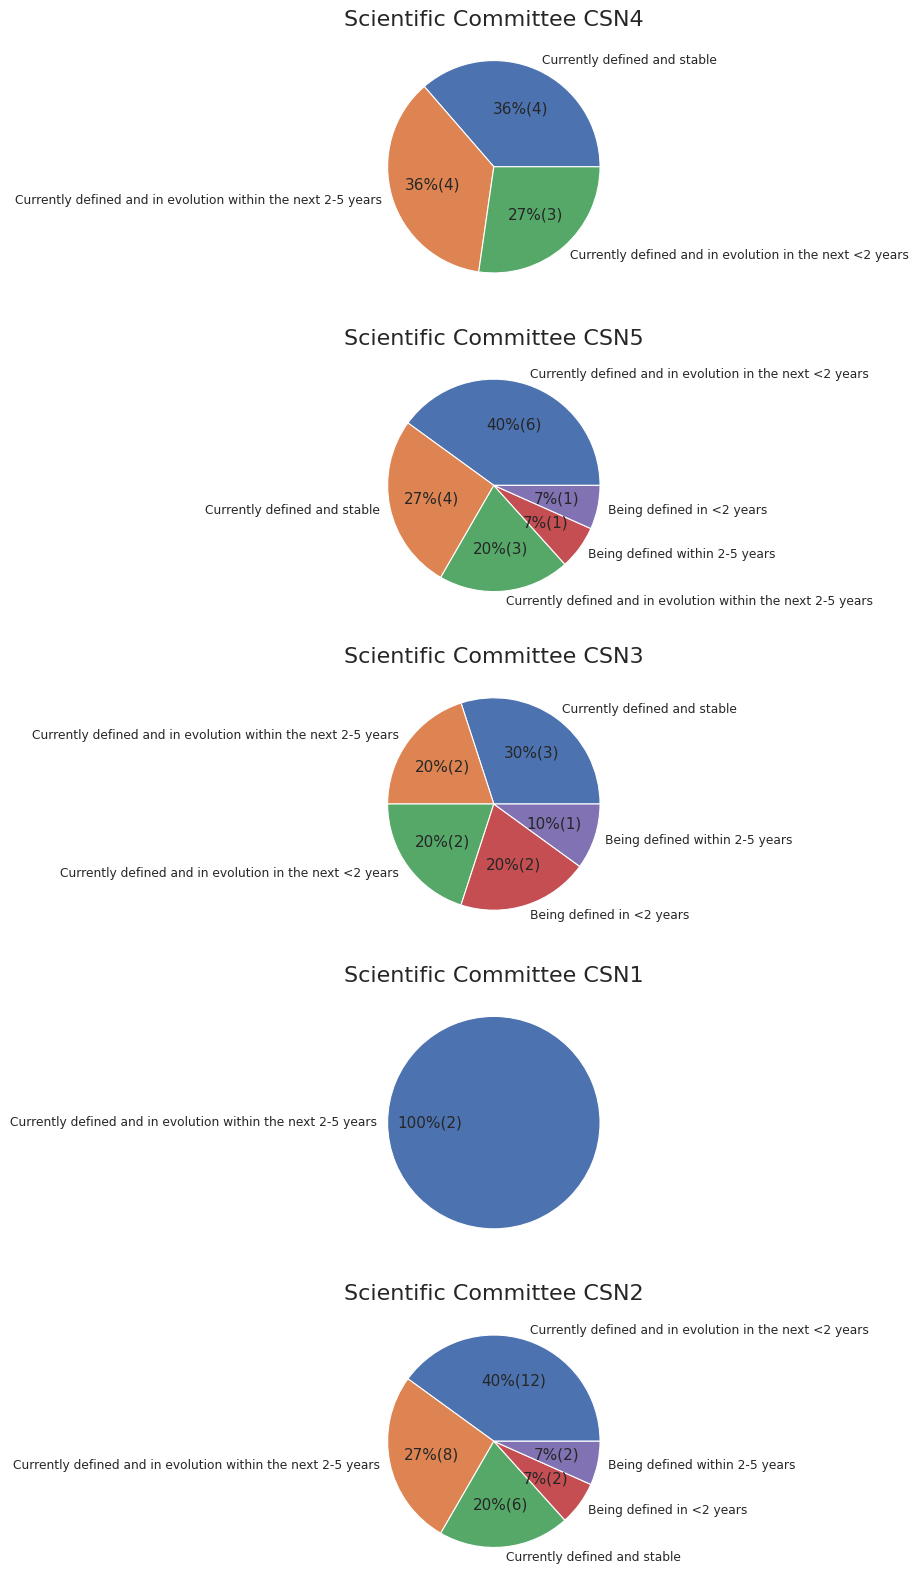

In [51]:

#data = df[(df["Scientific Committee"]=="CSN4") & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
#data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
#data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["Storage - size (I)"]
def pie_by_who_what(who, what):
  fig, ax = plt.subplots(5,figsize=(4,20))
  CSN = pd.unique(df[who])
  for i, csn in enumerate(CSN):
    data = df[(df[who]==csn)][what]
    elements = len(data)
    pd.value_counts(data).plot(kind='pie', ax=ax[i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
    ax[i].set_title(who+" "+csn)
  return ax
pie_by_who_what(who="Scientific Committee", what="Computing model evolution")
plt.show()

<div class="markdown-google-sans">

## pladge
</div>



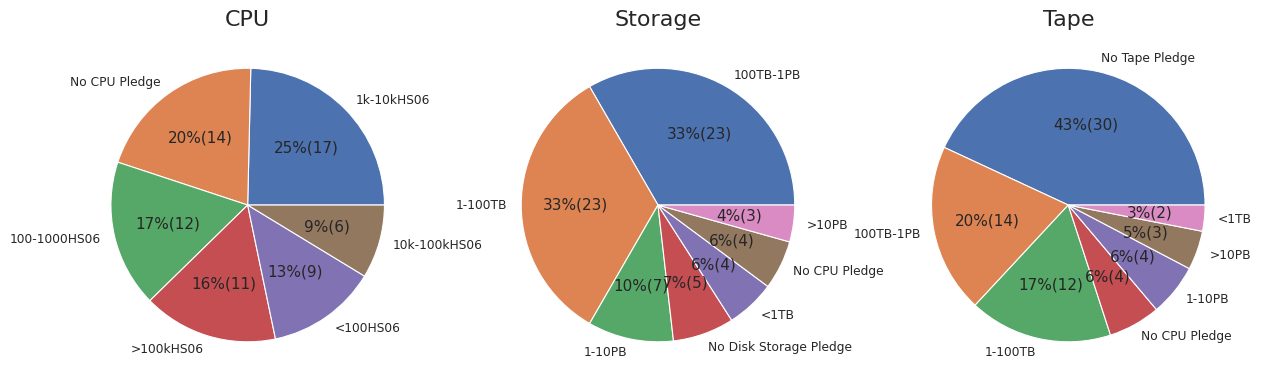

In [130]:
pledges = ["CPU - total amount (I)", "Storage - size (I)", "Tape - size (I)"]
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i, pledge in enumerate(pledges):
  data = df[pledge]
  elements = len(data)
  pd.value_counts(data).plot(kind='pie', ax=ax[i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
  ax[i].set_title(pledge.split(' ')[0])

plt.show()

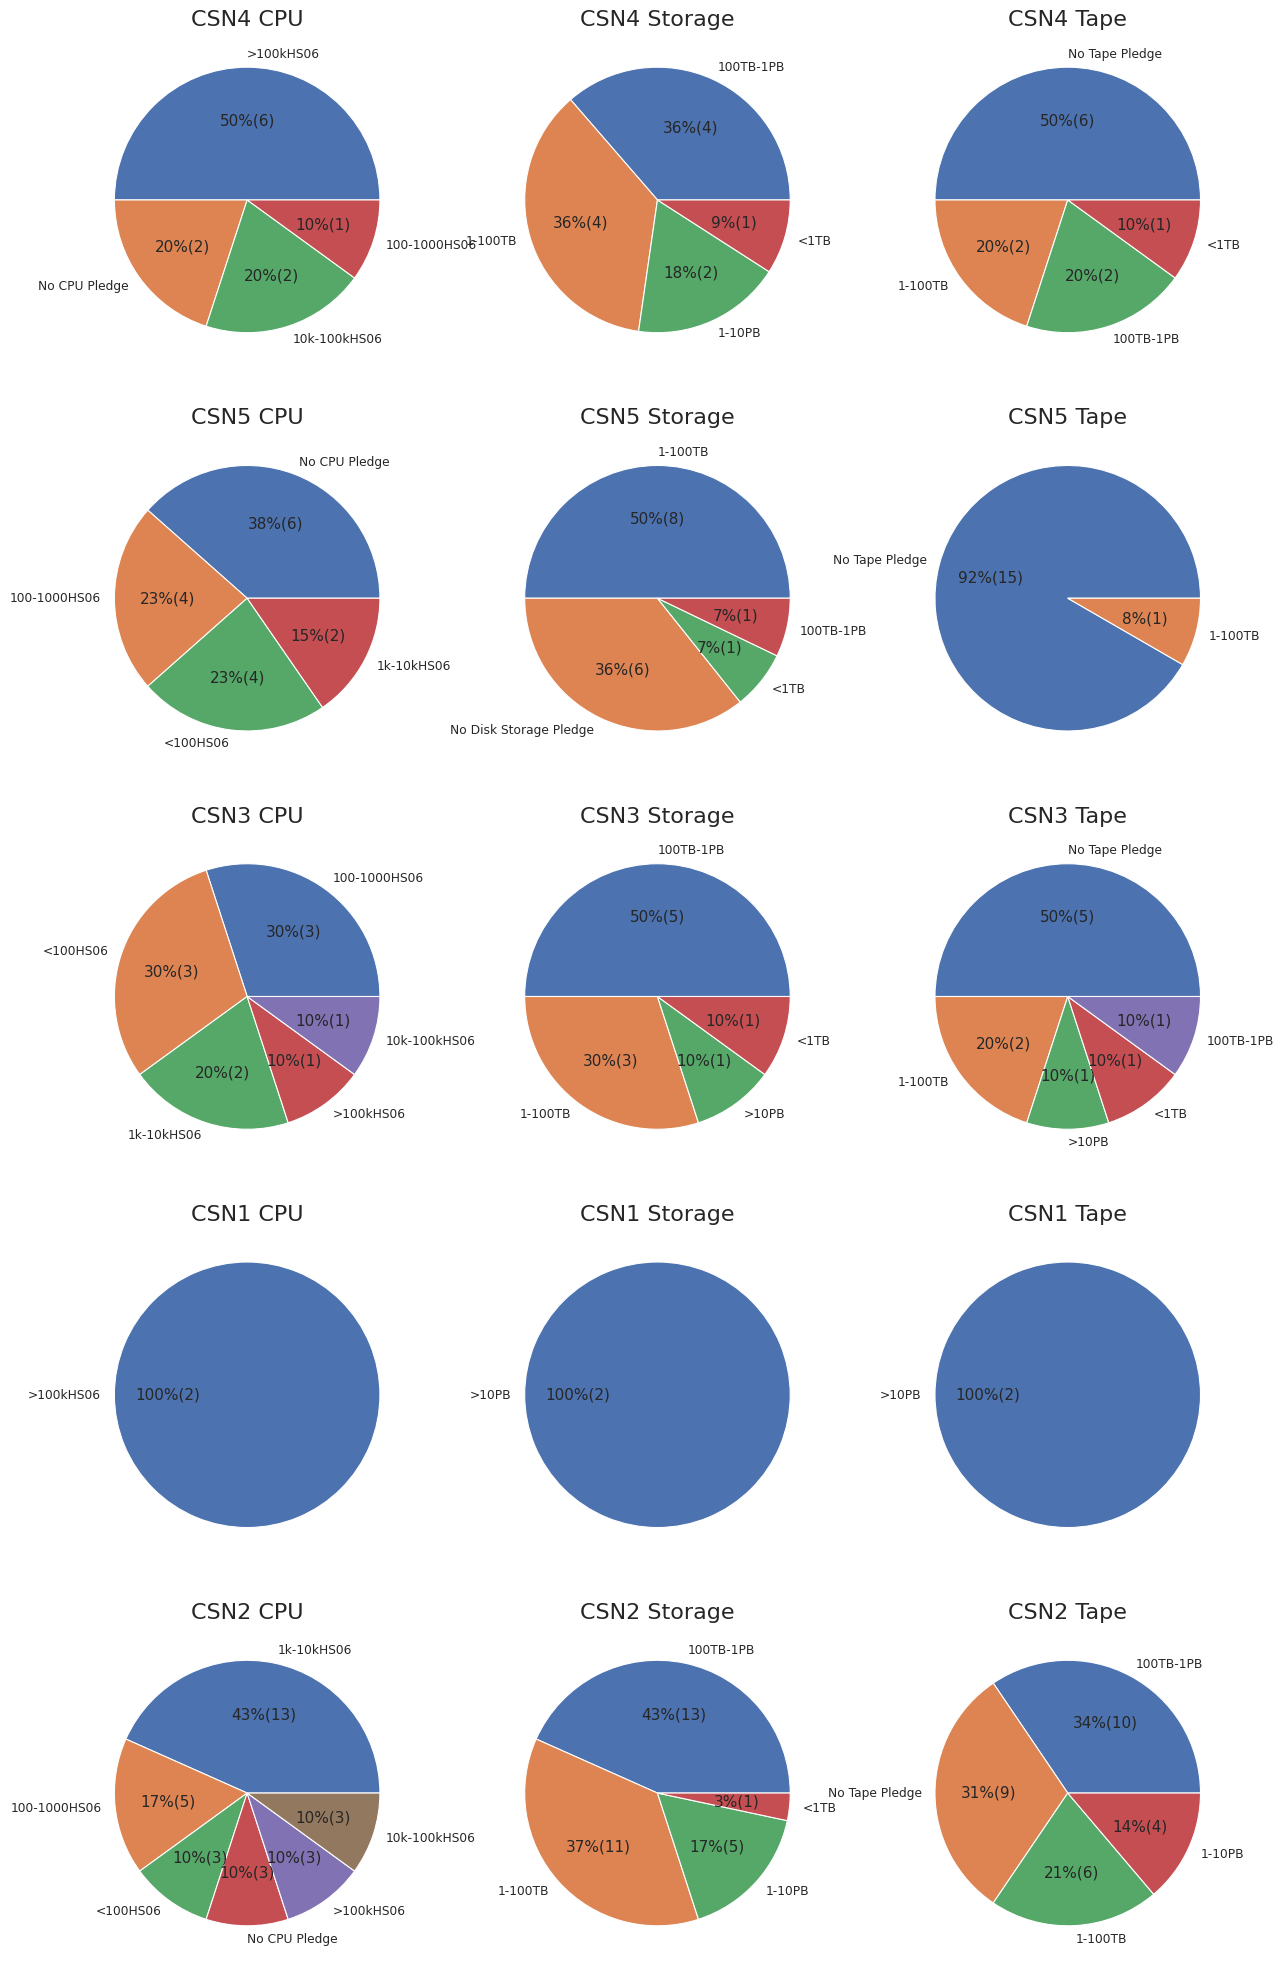

In [27]:
pledges = ["CPU - total amount (I)", "Storage - size (I)", "Tape - size (I)"]
fig, ax = plt.subplots(5,3,figsize=(15,25))
who="Scientific Committee"
CSN = pd.unique(df[who])
for i, pledge in enumerate(pledges):
  for j, csn in enumerate(CSN):
    data = df[(df[who]==csn)][pledge]
    elements = len(data)
    pd.value_counts(data).plot(kind='pie', ax=ax[j,i], autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="")
    ax[j,i].set_title(csn+" "+pledge.split(' ')[0])

plt.show()

In [19]:
df.columns

Index(['Timestamp', 'Email Address', 'Experiment or project/initiative',
       'Unnamed: 3', 'Computing model evolution', 'Real Data amount',
       'Real Data size', 'Data structure',
       'Metadata/calibrations/slow-control', 'Production sites', 'Workflow',
       'Data access', 'Details', 'Details, "arrows"', 'Details, "boxes"',
       'CPU - total amount (I)', 'CPU - HPC (I)', 'CPU - HTC',
       'CPU - interactive', 'CPU - batch system (I)', 'CPU - web based tools',
       'CPU - personal VMs', 'CPU - graphic access', 'CPU - services (I)',
       'CPU - temporary overpledge (I)', 'CPU - special environment (I)',
       'CPU - R&D', 'Storage - size (I)', 'Storage - experiment data (I)',
       'Storage - user data (I)', 'Storage - secondary data (I)',
       'Storage - executables and libraries', 'Storage - read-only',
       'Storage - POSIX', 'Storage - access (I)', 'Tape - size (I)',
       'Tape - access frequency (I)', 'Tape - inventory',
       'Tape - replicas and backups

In [177]:
what = "Storage - size (I)"
pd.unique(df[what])

array(['100TB-1PB', '1-10PB', 'No Disk Storage Pledge', '<1TB', '1-100TB',
       '>10PB'], dtype=object)

In [175]:
pledges = ["CPU - total amount (I)", "Storage - size (I)", "Tape - size (I)"]
what = pledges[1]
df.loc[df[what].isnull(), what]='No Tape Pledge'
pd.unique(df[what])

array(['No Tape Pledge', '1-100TB', '100TB-1PB', '>10PB', '1-10PB',
       '<1TB'], dtype=object)

AttributeError: ignored

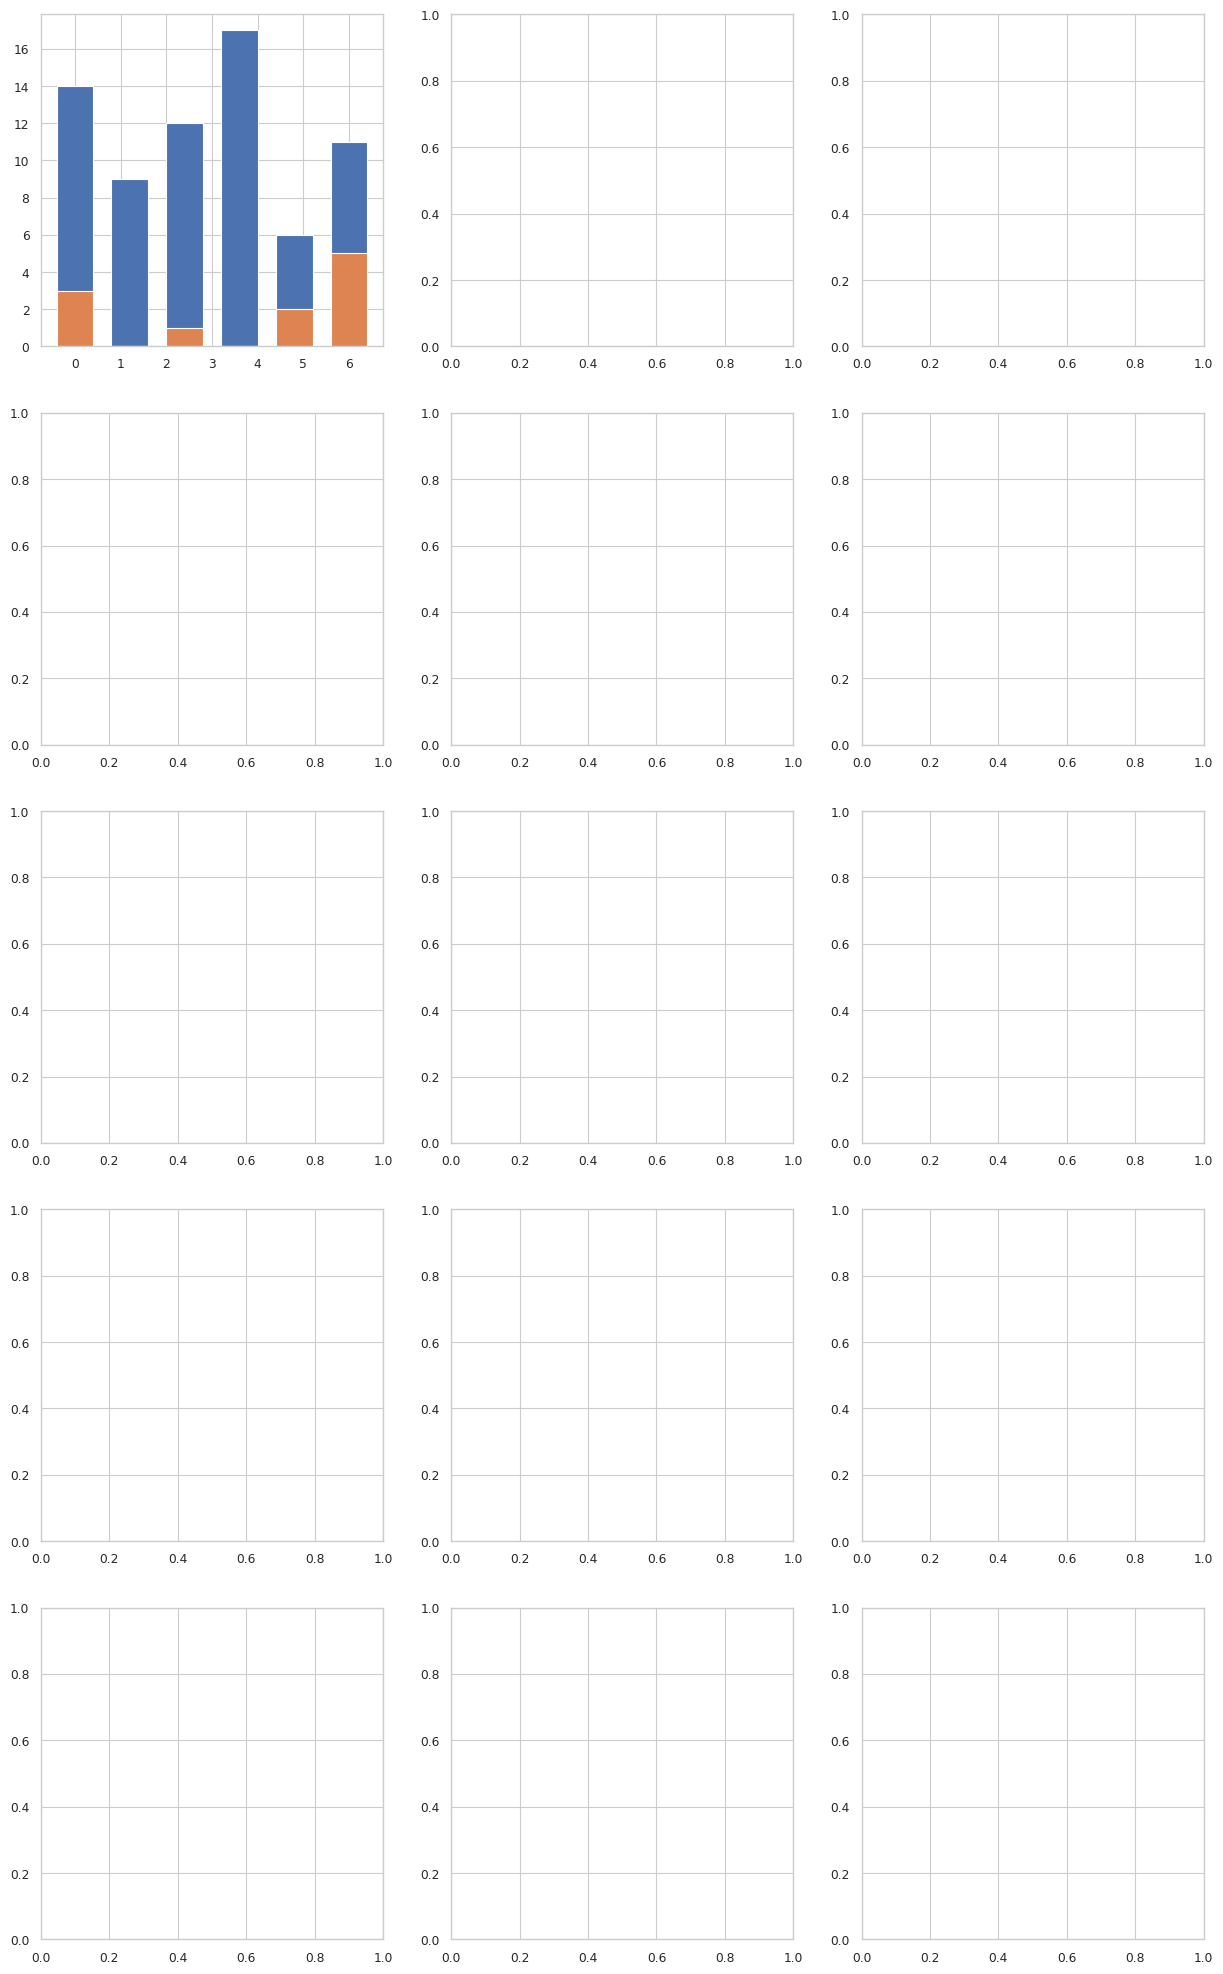

In [185]:
def ro_cpu(a):
  r = []
  r.append(a[1])
  r.append(a[4])
  r.append(a[2])
  r.append(a[3])
  r.append(a[5])
  r.append(a[0])
  return r
def ro_disk(a):
  r = []
  r.append(a[2])
  r.append(a[3])
  r.append(a[4])
  r.append(a[0])
  r.append(a[1])
  r.append(a[5])
  return r
def ro_tape(a):
  r = []
  r.append(a[0])
  r.append(a[2])
  r.append(a[3])
  r.append(a[4])
  r.append(a[5])
  r.append(a[1])
  return r
def hist_from_label(df, what, labels):
  data = []
  for i, label in enumerate(labels):
    data.append(len(df[df[what]==label]))
  return data

fig, ax = plt.subplots(5,3,figsize=(15,25))
CSN = pd.unique(df['Scientific Committee'])
pledges = ["CPU - total amount (I)", "Storage - size (I)", "Tape - size (I)"]
for i, pladge in enumerate(pledges):
  if pladge == "CPU - total amount (I)":
    df.loc[df[pladge].isnull(), pladge]='No CPU Pledge'
  elif pladge == "Storage - size (I)":
    df.loc[df[pladge].isnull(), pladge]='No Disk Storage Pledge'
  elif pladge == "Tape - size (I)":
    df.loc[df[pladge].isnull(), pladge]='No Tape Pledge'
  else:
    print ("Error no change")
  for j, csn in enumerate(CSN):
    labels = ro_cpu(pd.unique(df[pladge]))
    data = hist_from_label(df, pladge, labels)
    x = np.linspace(0, len(data), len(data))
    ax[j,i].bar(x, data, label=pladge)


    for i, csn in enumerate(CSN):
      data2 = hist_from_label(df[df['Scientific Committee']==csn], pladge, labels)
      ax[j,i].bar(x, data2, label=csn)
      ax[j,i].xticks(x, labels, rotation=45)
plt.legend()
plt.show()

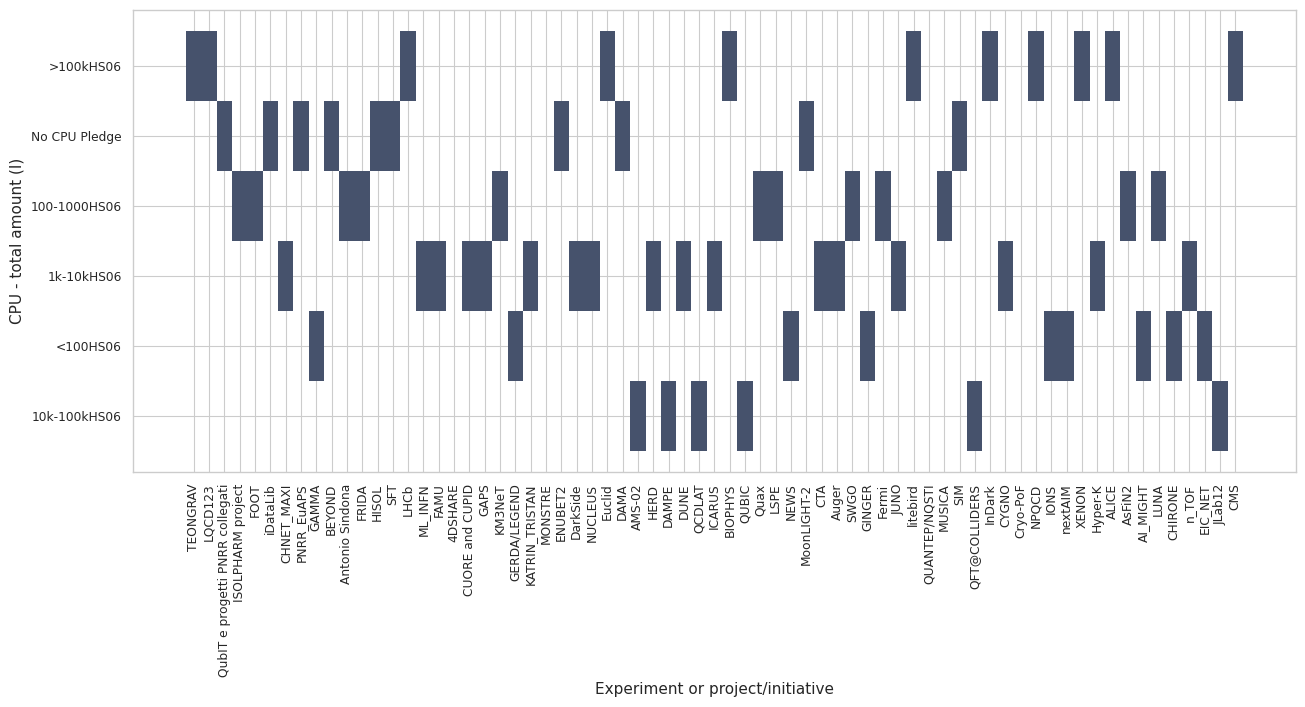

In [21]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(df, x="Experiment or project/initiative", y="CPU - total amount (I)")
ax.tick_params(axis='x', rotation=90)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=df, x="Experiment", y="where stored")
sns.histplot(data=df, x="Experiment or project/initiative", stat='probability', bins=13, color='r')
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production")
#plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])
plt.show()

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment or project/initiative", y="CPU - total amount (I)")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("DAQ [ev/y]")
plt.show()

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="DAQ rate events/y")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("DAQ [ev/y]")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="size KB")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("Ev size [KB]")
plt.show()

In [ ]:
df[['Email Address', 'Experiment']]

In [ ]:
df.columns

damp all db

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
from IPython.display import display
for i, field in enumerate(df.columns):
  if i> 2:
    # print(field)
    # data = df[['Experiment', field]].values
    #display(df[['Experiment', field]])
    display(data_table.DataTable(df[['Experiment', field]], include_index=False, num_rows_per_page=32))


**prudctio site**: Where data are produced, stored, etc...? From where are distributed? (include also metadata/calibrations/slow-control)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=df, x="Experiment", y="where stored")
sns.histplot(data=df, x="where stored", stat='probability', bins=4)
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production site and storage")
plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=df, x="Experiment", y="where stored")
sns.histplot(data=df, x="where", stat='probability', bins=13, color='r')
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production")
#plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
#colors = ["g", "w", "k", "y", "c"]
explode = [0, 0.1]
labels = ["restricted\n to collaboration", "open"]
elements = len(df["public"])
ax.pie(x=df.value_counts(df["public"]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="CPU (100HS06=10core)")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
#ax.set_ylabel("Ev size [KB]")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
what="CPU (100HS06=10core)"
sns.scatterplot(data=df[df[what]>0], x="RAM (GB)", y=what)
for i in range(df.shape[0]):
  if df[what][i]>0:
    x=df["RAM (GB)"][i]+df["RAM (GB)"][i]*0.03
    y=df[what][i]-df[what][i]*(i%2)*0.3
    plt.text(x=x, y=y, s=df["Experiment"][i])
#ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylabel("Ev size [KB]")
#ax.set_ylim(0,5000)
plt.show()

In [ ]:
df[df["CPU (100HS06=10core)"]>0]["CPU (100HS06=10core)"].sum()*10

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
colors = ["g", "w", "k"]
explode = [0, 0.1, 0]
labels = ["no", "testing", "yes"]
elements = len(df["HPC"])
ax.pie(x=df.value_counts(df["HPC"]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
ax.set_title('HPC', fontsize=18)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df[df["HPC"]>1], x="Experiment", y="HTC")
ax.tick_params(axis='x', rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("HTC [% of HPC]")
ax.set_title('percentage of HTC', fontsize=18)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
df['total'] = df.interactive+df.batch
sns.barplot(data=df, x="Experiment", y="total", color=sns.color_palette("Set2", 10)[1], label="bach")
sns.barplot(data=df, x="Experiment", y="interactive", color=sns.color_palette("Set2", 10)[2], label="interactive")
ax.tick_params(axis='x', rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("CPU batch/interactive [%]")
ax.set_title('batch/interactive', fontsize=18)
plt.legend()
plt.show()

In [ ]:
def maybe_pie(dbframe,what):
  fig, ax = plt.subplots(figsize=(6,6))
  explode = [0, 0.1, 0]
  labels = ["no", "yes", "in future"]
  elements = len(dbframe[what])
  ax.pie(x=dbframe.value_counts(dbframe[what]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
      textprops={'size': 'x-large'})
  ax.set_title(what, fontsize=18)
  plt.show()
def yesno_pie(dbframe, what):
  fig, ax = plt.subplots(figsize=(6,6))
  explode = [0, 0.1]
  labels = ["no", "yes"]
  elements = len(dbframe[what])
  ax.pie(x=dbframe.value_counts(dbframe[what]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
      textprops={'size': 'x-large'})
  ax.set_title(what, fontsize=18)
  plt.show()
maybe_pie(df,"web tool")

In [ ]:
df.columns

In [ ]:
maybe_pie(df,"personal VMs")
maybe_pie(df,"graphic access")
yesno_pie(df,"services")
yesno_pie(df,"temporary overpledge")
#maybe_pie("special environment")
maybe_pie(df,"R&D")



In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="file size GB", color=sns.color_palette("Set2", 10)[2])
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("FILE SIZE [GB]")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="TB", color='r')
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("STORAGE SIZE [TB]")
plt.show()

In [ ]:
df[df.TB>0].TB.sum()/1000


In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df[df["experiment data"]>=0], x="Experiment", y="experiment data", color=sns.color_palette("Set2", 10)[1])
ax.tick_params(axis='x', rotation=90)
# ax.set_yscale('log')
ax.set_ylabel("PECENTAGE OF EXPERIMENT DATA [%]")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="tape size", color='b')
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("TAPE SIZE [TB]")
plt.show()

In [ ]:
df[df["tape size"]>0]["tape size"].sum()/1000